In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
extcoh_uid = np.load('extcoh(1).npy')

In [37]:
uids = []
sex = []
age = []
df_lcu = []

path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
for f in csv_files:
    
    uid = int(f.split("/")[-1].split('.')[1][1:])
    
    if uid in extcoh_uid:
        df = pd.read_csv(f, index_col = 0)
        if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
            if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):

                df_lcu.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                sex.append(re.split('(\d+)',demo_info)[0])
                age.append(int(re.split('(\d+)',demo_info)[1]))
                uids.append(int(f.split("/")[-1].split('.')[1][1:])) 

path = os.getcwd()+'/u_shb/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
for f in csv_files:
    
    uid = int(f.split("/")[-1].split('.')[1][1:])
    
    if uid in extcoh_uid:
        df = pd.read_csv(f, index_col = 0)
        if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
            if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):

                df_lcu.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                sex.append(re.split('(\d+)',demo_info)[0])
                age.append(int(re.split('(\d+)',demo_info)[1]))
                uids.append(int(f.split("/")[-1].split('.')[1][1:])) 
                
path = os.getcwd()+'/u_fat/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
for f in csv_files:
    
    uid = int(f.split("/")[-1].split('.')[1][1:])
    
    if uid in extcoh_uid:
        df = pd.read_csv(f, index_col = 0)
        if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
            if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):

                df_lcu.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                sex.append(re.split('(\d+)',demo_info)[0])
                age.append(int(re.split('(\d+)',demo_info)[1]))
                uids.append(int(f.split("/")[-1].split('.')[1][1:])) 
    
path = os.getcwd()+'/extcoh/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
for f in csv_files:
    
    uid = int(f.split("/")[-1].split('.')[1][1:])
    
    if uid in extcoh_uid:
        df = pd.read_csv(f, index_col = 0)
        if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
            if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):

                df_lcu.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                sex.append(re.split('(\d+)',demo_info)[0])
                age.append(int(re.split('(\d+)',demo_info)[1]))
                uids.append(int(f.split("/")[-1].split('.')[1][1:])) 

In [15]:
dfagg = []
for df in df_lcu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
 
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    d_agg['day_totest'] 
    d_agg = d_agg[(pd.to_timedelta(d_agg.day_totest).dt.days <= 180) & (pd.to_timedelta(d_agg.day_totest).dt.days >= -62)]
    d_agg['steps'] = d_agg['steps'] - 4
    dfagg.append(d_agg)

In [16]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(1,len(elements)+1):
        if i >= window_size:
            wi_days.append(elements[i-window_size:i])
        elif i < window_size:
            wi_days.append(elements[:i])
    return wi_days

## rhr

In [18]:
seas = pd.read_csv('mean_rhr_pdps.csv',index_col=0)

In [19]:
def get_rhr(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd.dropna()) > 0:
 
        rhr_rel = subd['rhr_cl'].dropna()
         
        if len(rhr_rel ) >= 20  :
            return  rhr_rel.mean(), rhr_rel.std() #,0, hr_rel.mean()
        else:
            return 0,0
    else:
        return 0,0

In [24]:
rhr_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(df_lcu)))
 
i =0
for ui in range(len(df_lcu)):# np.where(s_i & a_i)[0]:
    df = df_lcu[ui].copy()
    df = df[(pd.to_timedelta(df.day_totest).dt.days >= -62) &(pd.to_timedelta(df.day_totest).dt.days <= 180)]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    sc = df.source.unique()[0]
    seas_sc = seas[seas.source == sc].copy()
    seas_sc['date'] = pd.to_datetime(seas_sc['date'])
    df = df[['start','rhr','date','day_of_week', 'dt','day_totest', 'week_totest','phase']]
    df_seas = pd.merge(df,seas_sc, how = 'outer', on ='date')
    #df_seas = df_seas.dropna()
    df_seas['rhr_cl'] = df_seas['rhr'] - df_seas['mean']
    #df['day_totest'] = df['date'] - df['dt']
    
    
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        rhrm, rhrstd = get_rhr(df_seas[df_seas['date'].isin(wi_list[wi])])
        rhr_mean.loc[rhr_mean.index.isin(dtt_list[wi]),i] =  rhrm
         
    i += 1

In [32]:
len(rhr_mean.T)/9

27.0

In [47]:
idxs = []
excl_u = []
for d in range(len(rhr_mean.T)):
    if np.count_nonzero(rhr_mean[d] == 0)/len(rhr_mean[d]) > 0.3:
        idxs.append(d)
        excl_u.append(uids[d])

In [48]:
len(idxs)

40

In [58]:
len(df_lcu) #- 40

243

In [56]:
204/6

34.0

In [61]:
len([d for d in range(len(df_lcu)) if d not in idxs])

203

In [65]:
rhr_mean[40]

-62 days    10.616581
-61 days     9.077001
-60 days     9.468305
-59 days    11.322725
-58 days    10.569576
              ...    
176 days    11.748244
177 days    11.748244
178 days    11.748244
179 days    11.748244
180 days    11.748244
Freq: D, Name: 40, Length: 243, dtype: object

IndexError: index 242 is out of bounds for axis 0 with size 204

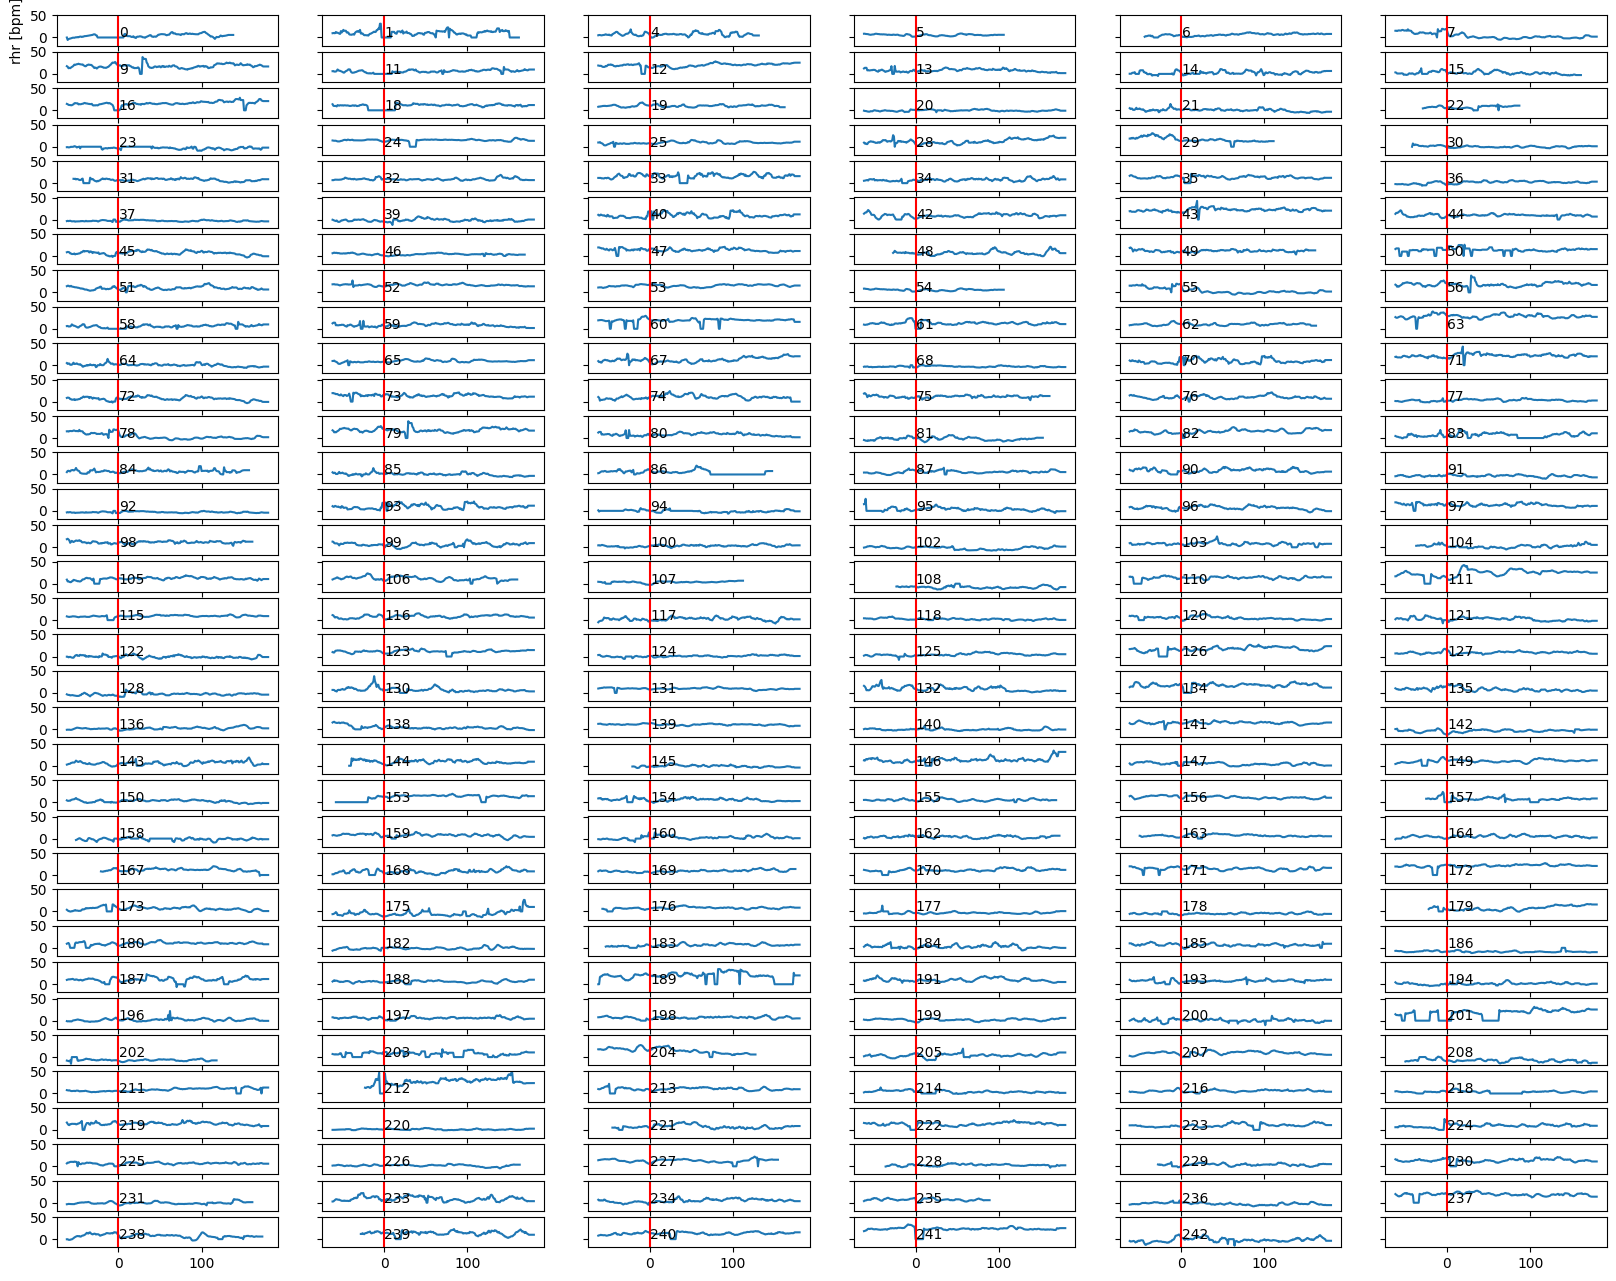

In [63]:
fig, axs = plt.subplots(34,6, figsize=(20, 16
                                      ), facecolor='w', edgecolor='k',sharex=True, sharey = True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
clean_u = [d for d in range(len(df_lcu)) if d not in idxs]
i = 0
for d in clean_u:
     
    axs[i].plot(rhr_mean.index.days,rhr_mean[d])



    axs[i].axvline(x=0, ymin = 0, ymax =1,color ='red')
    axs[i].text(0.35, 0.5, str(d))

    if i == 0:

        axs[i].set_ylabel(r'rhr [bpm]') 
    if i== 202:
        axs[i].set_xlabel('days to test')
    i += 1

## rhr hr

In [75]:
def get_md(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd) > 0:
        night = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna()
        day = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna()
        rhr_rel = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['% of MHR'].dropna()
        if len(day) >= 14 and len(night) >= 14:
            return night.mean(), night.std(), day.mean(), day.std()#, rhr_rel.mean(), rhr_rel.std()
        elif len(day) >= 14 and len(night) <= 14:
            return 0,0, day.mean(), day.std()#, rhr_rel.mean(), rhr_rel.std()
        elif len(day) <= 14 and len(night) >= 14:
            return night.mean(), night.std(), 0,0#, rhr_rel.mean(), rhr_rel.std()
        else:
            return 0,0,0,0#,0,0
    else:
        return 0,0,0,0#,0,0

In [76]:
hr = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62), datetime.timedelta(days = 180)), columns = range(len(df_lcu)))
rhr = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62), datetime.timedelta(days = 180)), columns = range(len(df_lcu)))

i =0
for ui in range(len(df_lcu)):# np.where(s_i & a_i)[0]:
    df = df_lcu[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')

    wi_list = sliding_window(df['date'].unique(),14)
    dtt_list = sliding_window(df['day_totest'].unique(),14)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds = get_md(df[df['date'].isin(wi_list[wi])])
        hr.loc[hr.index.isin(dtt_list[wi]),i] =  dm
        rhr.loc[rhr.index.isin(dtt_list[wi]),i] =  nm
         
    i += 1

In [117]:
hr = hr.replace(0,np.nan)
rhr = rhr.replace(0,np.nan)

In [367]:
use = [2,3,4,5,6,7,9,11,12,13,14,15,16,17,19,20,22,24,25,26,28,30,32,34,35,36,37,39,41,42,45,46,48,49,50,51,52,53,54,55,56,58,59,60,61,62,65,67,68,72,74,75,76,77,78,79,80,81,82,87,89,91,92,96,98,100,102,105,106,107,108,110,111,115,116,118,119,120,121,122,123,124,125,127,128,131,135,136,138,139,140,141,142,145,147,148,149,150,152,153,155,156,159,160,162,163,164,165,166,167,171,172,173,176,177,178,179,180,181,182,183,186,187,188,191,194,196,197,198,199,200,202,203,205,207,208,211,213,214,215,216,218,220,221,222,223,224,225,226,227,231,235,236,238,241]

In [400]:
len(use)+6/10


155.6

In [407]:
len(use)/5

31.0

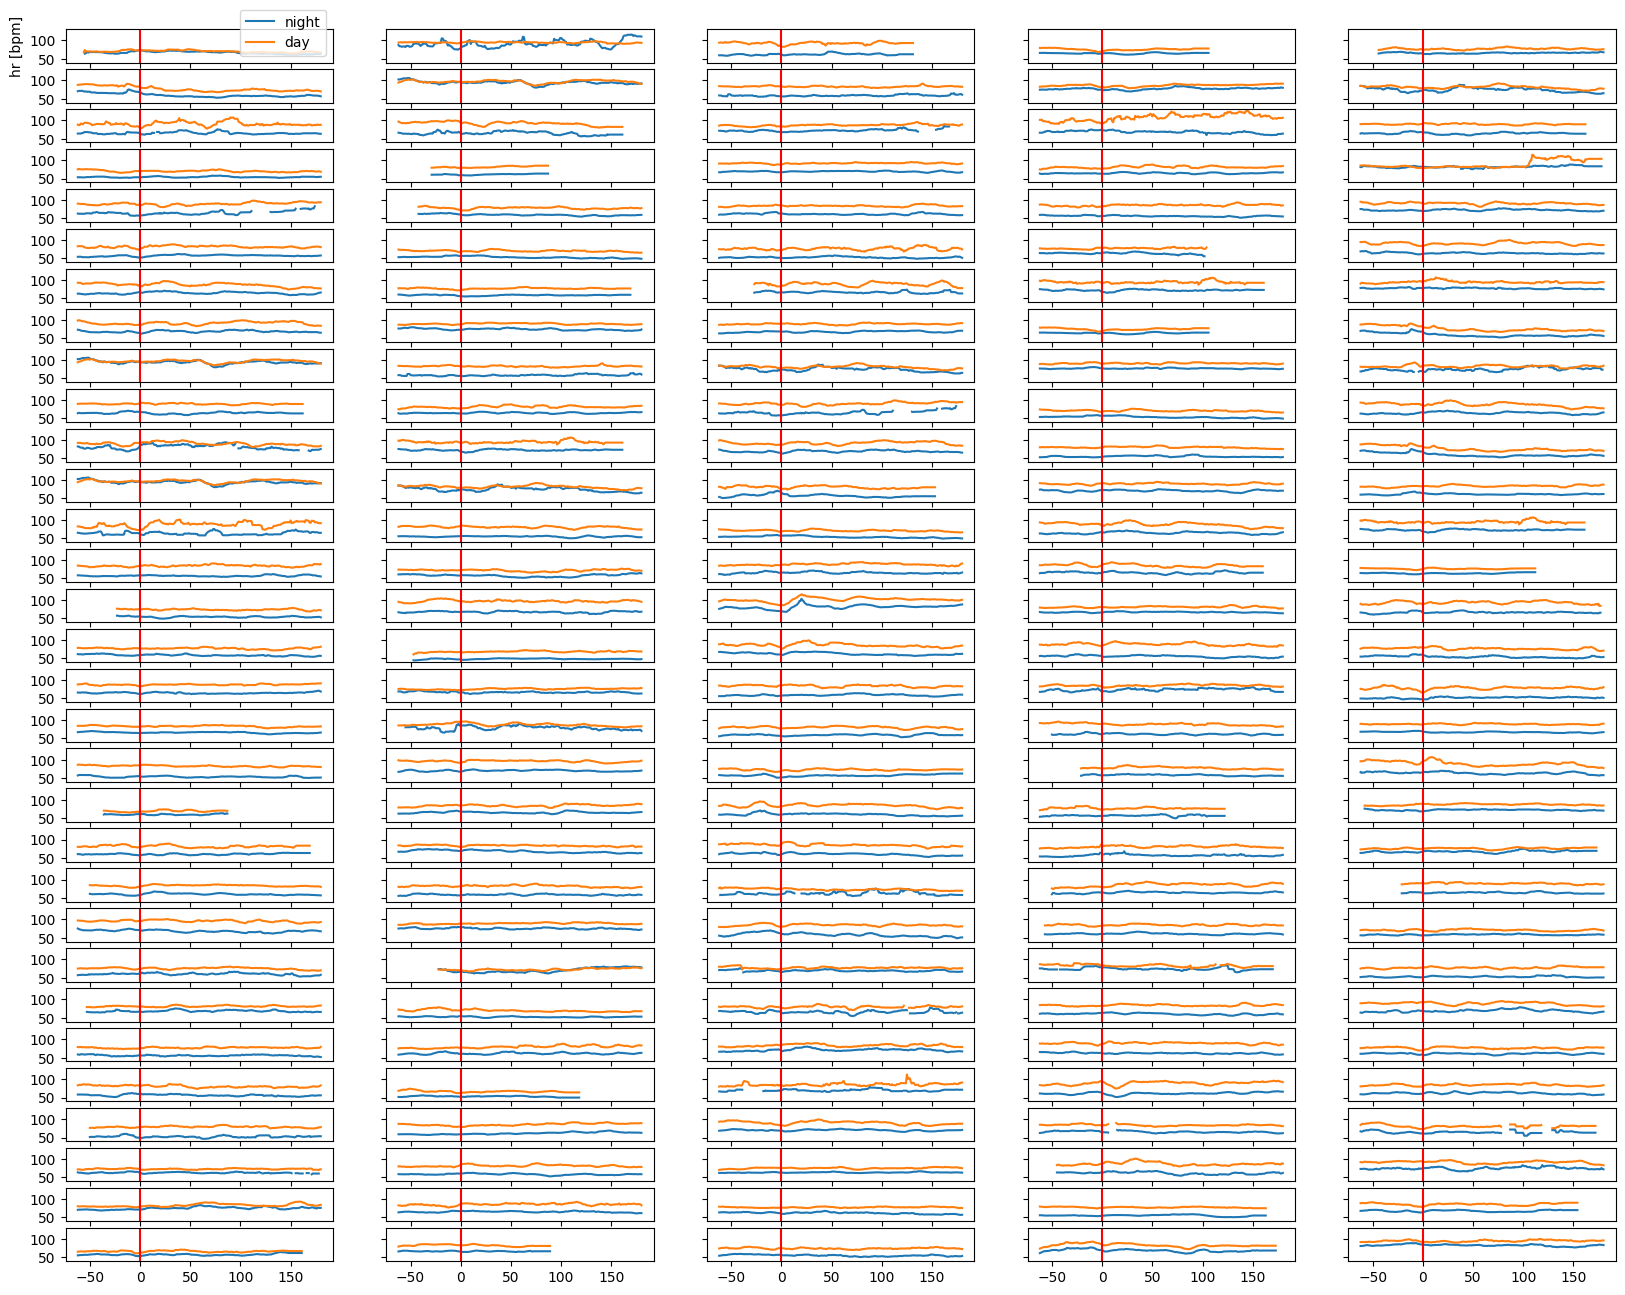

In [408]:
fig, axs = plt.subplots(31,5, figsize=(20, 16
                                      ), facecolor='w', edgecolor='k',sharex=True, sharey = True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for d in use:
    axs[i].plot(rhr.index.days,rhr[d])
    axs[i].plot(hr.index.days,hr[d])
    
    
    axs[i].axvline(x=0, ymin = 0, ymax =1,color ='red')
        
    if i == 0:
        axs[i].legend(['night','day'], loc = 'lower right')
        axs[i].set_ylabel(r'hr [bpm]') 
    if i== 202:
        axs[i].set_xlabel('days to test')
    i+=1
        

## high act

In [411]:
n_sps = []
un_week = []
for d in dfagg:
    n_sp = []
    for w in d['week_totest'].unique():
        dpw = d[d['week_totest'] == w].groupby('date').sum()
        n_sp.append(len(dpw[dpw['steps'] > 10000]))
    un_week.append(d['week_totest'].unique())
    n_sps.append(n_sp)

In [ ]:
fig, axs = plt.subplots(31,5, figsize=(18, 14
                                      ), facecolor='w', edgecolor='k',sharex=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for d in use:

    axs[d].scatter(un_week[d], n_sps[d],s=.3)
    #axs[d].plot([0]*max(n_sps[d]), list(range(max(n_sps[d]))),c='r')
    axs[d].axvline(x=0,color='r')
    if d == 0:
        axs[d].set_ylabel(r'# high act'+'\n'+'per week')
    if d == 51:
        axs[d].set_xlabel('week to test')

In [7]:
# dataframes mit werten fuer fehlende tage einbauen 

In [8]:
mins = []
maxs = []
minw = []
maxw = []
for df in df_lcu:
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())

In [12]:
df_cu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(df_lcu)))
df_cu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(df_lcu)))
df_cu_night_mean_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(df_lcu)))
df_cu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(df_lcu)))

In [13]:
for u in range(len(df_lcu)):
    df = df_lcu[u]
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    df = df.sort_values(by='date')
    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),14)
    dtt_list = sliding_window(df['day_totest'].unique(),14)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds, rhrm, rhrs = get_md(df[df['date'].isin(wi_list[wi])])
        df_cu_day_mean.loc[df_cu_day_mean.index.isin(dtt_list[wi]),u] =  dm
        df_cu_night_mean.loc[df_cu_night_mean.index.isin(dtt_list[wi]),u] =  nm
        df_cu_night_mean_rel.loc[df_cu_night_mean_rel.index.isin(dtt_list[wi]),u] =  rhrm
        if dm != 0:
            df_cu_diff.loc[df_cu_night_mean.index.isin(dtt_list[wi]),u] = (dm - nm)/dm
        

In [14]:
df_cu_diff = df_cu_diff[(df_cu_diff.index >= datetime.timedelta(days = -274)) &(df_cu_diff.index <= datetime.timedelta(days = 286))]
df_cu_night_mean_rel = df_cu_night_mean_rel[(df_cu_night_mean_rel.index >= datetime.timedelta(days = -274)) &(df_cu_night_mean_rel.index <= datetime.timedelta(days = 286))]

In [15]:
wks = []
for w in range(-40,41):
    for d in range(7):
        wks.append(w)

In [16]:
plt.rcParams['font.size']=12

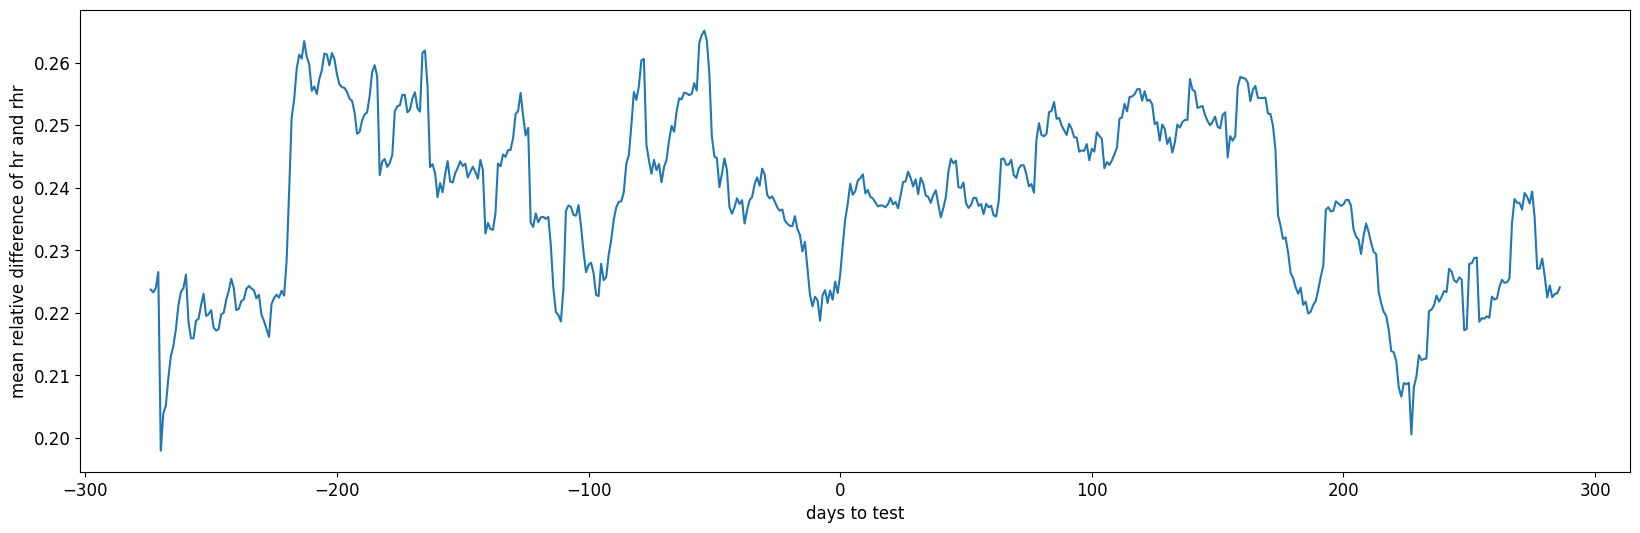

In [17]:
plt.figure(figsize=(20,6))
plt.plot(df_cu_diff.index.days,df_cu_diff.mean(axis=1));
#plt.plot(df_cu_night_mean.index.days,df_cu_night_mean.mean(axis=1));
#plt.errorbar(df_cu_diff.index.days,df_cu_diff.mean(axis=1),yerr=df_cu_diff.std(axis=1)/np.sqrt(df_cu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
plt.ylabel('mean relative difference of hr and rhr');

In [34]:
df_cu_night_mean_rel.replace(0, np.nan, inplace=True)

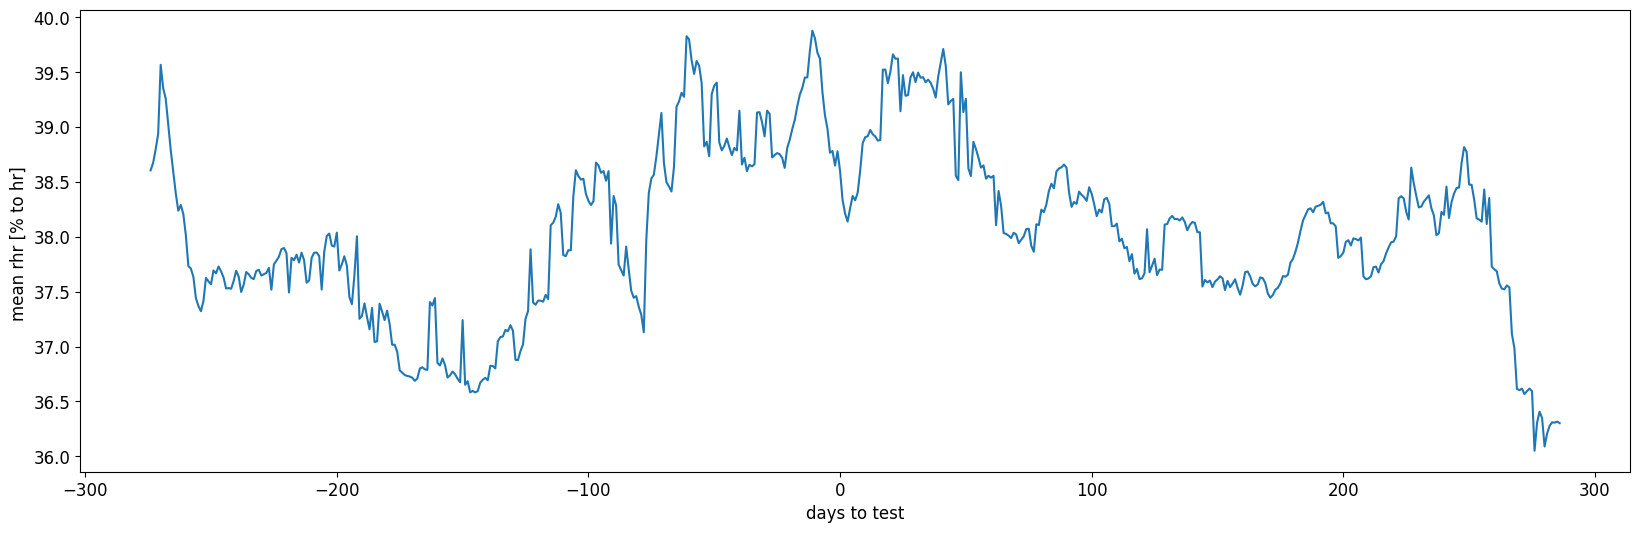

In [35]:
plt.figure(figsize=(20,6))
#plt.plot(df_cu_diff.index.days,df_cu_diff.mean(axis=1));
plt.plot(df_cu_night_mean_rel.index.days,df_cu_night_mean_rel.mean(axis=1));
#plt.errorbar(df_cu_diff.index.days,df_cu_diff.mean(axis=1),yerr=df_cu_diff.std(axis=1)/np.sqrt(df_cu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
plt.ylabel('mean rhr [% to hr] ');

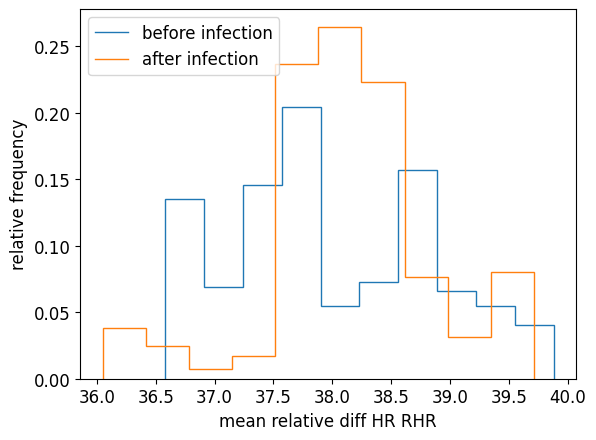

In [36]:
meandiff = df_cu_night_mean_rel.mean(axis=1).values
md_bt = meandiff[:np.where(df_cu_diff.index.days == 0)[0][0]]
md_bt = md_bt[md_bt != 0] 
md_at = meandiff[np.where(df_cu_diff.index.days == 0)[0][0]:]
md_at = md_at[md_at != 0]  
n_dbt, binsbt = np.histogram(md_bt)
n_dat, binsat = np.histogram(md_at )
plt.stairs(n_dbt/len(md_bt), binsbt, fill=False)
plt.stairs(n_dat/len(md_at), binsat, fill=False)
plt.legend(['before infection','after infection'], loc='upper left')
plt.xlabel('mean relative diff HR RHR');
plt.ylabel('relative frequency');

## high activity

In [ ]:
cu_ha = pd.DataFrame(index=list(range(-40,41)), columns=range(len(dfagg)))

In [ ]:
for ui in range(len(dfagg)):
    d_agg = dfagg[ui]
     
    for w in cu_ha.index:
        d = d_agg[d_agg['week_totest']==w]
        cu_ha.iloc[w,ui] = len(d[(d['hr'] > 100)&(d['steps'] > 2000)])
     

In [ ]:
bl = cu_ha[(cu_ha.index < -1)&(cu_ha.index > -7)].mean()
bl_dev = cu_ha - bl

In [ ]:
bl_dev 

In [ ]:
plt.plot(bl_dev.mean(axis=1))
plt.axhline(y=0,color='r')
plt.xlabel('weeks to test')
plt.ylabel('diff to mean times of high activity p week');

In [ ]:
for i in range(4):
    plt.scatter(bl_dev.index, bl_dev.iloc[:,i]);
    plt.axvline(x=0,c='r');

In [ ]:
plt.plot(bl_dev.mean(axis=1))

In [ ]:
bl

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18, 8
                                      ), facecolor='w', edgecolor='k',sharex=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for d in range(len(nsps)):

    axs[d].scatter(un_week[d], nsps[d],s=6
                  )
    #axs[d].plot([0]*max(n_sps[d]), list(range(max(n_sps[d]))),c='r')
    axs[d].axvline(x=0,color='r')
    axs[d].set_xlabel('weeks to test')
    axs[d].set_ylabel('# high activity');

In [ ]:
bl

In [ ]:
i = 1

bl = np.array(nsps[i])[un_week[i] < 0].mean()
(np.array(nsps[i])[un_week[i] >= 0] - bl)

In [ ]:
d_agg = dfagg[2]

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(12,5), sharey=True, sharex = True)
phases = ['pre', 'acute', 'sub-acute', 'post']
for ph in [0,1,2,3]:
  
    dfph = d_agg[d_agg['phase'] == ph]
    
    if ph == 0:
        n_a,bins = np.histogram(dfph[dfph['steps'] >4]['steps'])
    else: 
        n_a, _ = np.histogram(dfph[dfph['steps'] >4]['steps'], bins = bins)
    ax[ph].stairs(n_a/len(dfph[dfph['steps'] >4]['steps']), bins, fill=False)
 
    ax[ph].set_title(phases[ph])
    ax[ph].set_xlabel('steps');
ax[0].set_ylabel('relative frequency');

In [ ]:
d_agg = dfagg[2]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,10), sharey=True, sharex = True)
phases = ['pre', 'acute', 'sub-acute', 'post']
for ph in [0,1,2,3]:
  
    dfph = d_agg[d_agg['phase'] == ph]
    
    if ph == 0:
        n_a,bins = np.histogram(dfph[dfph['steps'] >4]['steps'])
    else: 
        n_a, _ = np.histogram(dfph[dfph['steps'] >4]['steps'], bins = bins)
    ax.stairs(n_a/len(dfph[dfph['steps'] >4]['steps']), bins, fill=False)
 
    
    ax.set_xlabel('steps');
ax.legend(phases )
ax.set_ylabel('relative frequency');